# 30574 Earth observations for monitoring changes (EO4Change) exercise with Sentinel-5P.
In this exercise you will download using an API, display and investigate ESA documentation before creating and displaying a Sentinel-5P Level-3 product based on Level-2 files.

### Setting up the code and installing the necessary packages. If it crashes, try again.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
    30574 Earth observations for monitoring changes (EO4Change) exercise with Sentinel-5P.
"""

# -- File info -- #
__author__ = ['Andreas R. Stokholm', 'Pau Fabregat Carrascal', 'Sebastian B. Simonsen']
__copyright__ = ['A Stokholm', 'PF Carrascal', 'SB Simonsen']
__contact__ = ['stokholm@space.dtu.dk', 'pfca@dtu.dk', 'ssim@space.dtu.dk']
__version__ = '6.1.1'
__date__ = '2025'


# -- Install Cartopy -- #
!pip install Cartopy
import cartopy.crs as ccrs


Install conda

In [ ]:
# -- Install conda -- #
!pip install -q condacolab
import condacolab
condacolab.install()


To create a level-3 product, we need the package "HARP", which can be installed with conda. If it crashes, try again, or try to restart the session in "Runtime".

In [ ]:
# -- Install harp -- #
!conda install -c conda-forge harp

Import the modules and setup google drive. Replace the gdrive path. Accept Google's request for permissions.

In [ ]:
# -- Built-in modules -- #
import os

# -- Third-party modules -- #
import cartopy.crs as ccrs
import datetime
import harp
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import xarray as xr

# -- Setup google drive -- #
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# -- Insert your code -- #


# Replace with your folder path.
%cd /gdrive/MyDrive/EO4Change/ex/S5P ex


# -- End of your code -- #



# Q1, downloading the data:

In the following, you need the usename and password for the Copernicus Browser to set up the API permission. Afterwards, you need to specify the product you want to use and select the dates for the data search. There are up to 3 files per day and can be many MB each. However, there are some cases where no information is available at the specified area, e.g. due to clouds. Therefore, it may be useful to have a time range of a couple of days. Finally, you need to specify the area for the data search.

In [ ]:

# -- Insert your code -- #

user = ''  # Insert your Copernicus Browser username.
password = ''  # Insert your Copernicus Browser password associated with the username.

data_collection = "SENTINEL-5P"
product_type = 'L2__'  # e.g. 'L2__<species>___'. In this context, species is another word for molecule. See https://sentiwiki.copernicus.eu/web/s5p-products#S5PProducts-L2S5P-Products-L2
processingMode = 'RPRO'

# Note, there can be up to 3 files for any given day.
start_date = datetime.date(YYYY, MM, DD)   # start date
end_date = datetime.date(YYYY, MM, DD)   # end date

# Format for POLYGON should be POLYGON((longitude latitude, longitude latitude, ..)). E.g. use https://geojson.io/#map=2/0/20 to find coordinates and change the format to fit the POLYGON function.
# Easiest is to make a rectangle with four corner coordinates.
aoi = "POLYGON((LONGITUDE LATITUDE, LONGITUDE LATITUDE, ...))'" # Bounding Box


# -- End of your code -- #


Next, we can request the data using the ESA dataspace API. You just have to run the proceeding cell. The files may take some minutes to download and will end up in the folder the specified previously.

In [ ]:
def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]

access_token = get_access_token(user, password)

# Request Session
headers = {"Authorization": f"Bearer {access_token}"}
session = requests.Session()
session.headers.update(headers)

# Get all season/products for the specified range of dates
json = requests.get(f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq '{data_collection}' "\
                    f"and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') "\
                    f"and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'processingMode' and att/OData.CSC.StringAttribute/Value eq '{processingMode}') "\
                    f"and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}) "\
                    f"and ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/Start lt {end_date}T00:00:00.000Z"\
                    f"&$top=300", stream=True).json()

df = pd.DataFrame.from_dict(json['value'])

# If not empty, download all mentioned sproducts (.zip format, empty or/and full)
if (df.empty):
    print('Empty request')
else:
    for n_session, (session_id, session_name) in enumerate(zip(df['Id'], df['Name'])):
        print('Processing session')

        url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({session_id})/$value"
        response = session.get(url, headers=headers, stream=True)

        with open(os.path.join(".", f"{session_name}"), "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)

Processing session
Processing session
Processing session
Processing session
Processing session
Processing session
Processing session
Processing session
Processing session


# Q2, displaying a Level-2 file:
In this part of the exercise, you will display one of the downloaded files on a world map. Depending on what product you have downloaded, the product name will vary. To find out the desired product name, look up the
Product User Manual (PUM), e.g. "PUM-NO2" https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-5p/products-algorithms. This will help you get familiar with the type of documentation which ESA offer.
(hint: look in the chapter "Description of the 'molecule' product" in the section "Group "PRODUCT" 'molecule'". You are looking for a product name, e.g. "..._tropospheric_column", depending on the product type.

Again, you may have to try different files as some may be empty (despite the large file size). Particularly areas of open water can be problematic.
Fill out the file and the product name and run. Optionally, you can add units to your colorbar or change the extent to cover only your region of interest. What is the satellite measuring? Why does the satellite cover more towards the polar regions?
You can add colorbar units with cbar.set_label('unit'). The unit can be found by s5p_product['your product'].attrs['units'].


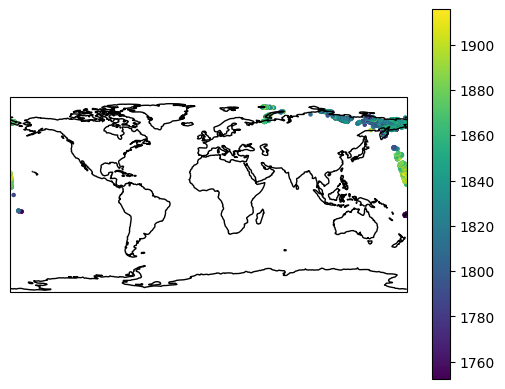

In [ ]:
# -- Insert your code -- #


file = ''  # Name of the level-2 file.
s5p_product_name = ''  # Name of the product in the level-2 file.


# -- End of your code -- #

# Open the .nc file.
s5p_product = xr.open_dataset(file, group='PRODUCT')

# Make the figure have lat lon projection.
s5p_fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Apply coastlines. Resolution can be 10m, 50m or 110m. Higher resolution may be slower.
ax.coastlines(resolution='110m', color='black', linewidth=1)

# Plot the product as a scatter plot. Note that x=lon and y=lat.
plt.scatter(x=s5p_product['longitude'], y=s5p_product['latitude'],
            c=s5p_product[s5p_product_name].squeeze(),
            vmin=np.nanquantile(s5p_product[s5p_product_name], q=0.01),
            vmax=np.nanquantile(s5p_product[s5p_product_name], q=0.99))


# -- Insert your code -- #


cbar = plt.colorbar()
# The figure can be saved with s5p_fig.savefig('cool_s5p_fig.png', format='png').


# -- End of your code -- #

plt.show()

# Q3, Level-3 product from multiple level-2 products.
To help us with aligning pixels across measurements, we utilize the HARP package through a Python interface. You can find documentation on HARP @ https://stcorp.github.io/harp/doc/html/index.html

To make a level-3 product, we need to tell HARP what type of product we want it to process, what the quality validity should be, and we need to define a grid. Afterwards, HARP will process each S5P file. Afterwards, the processed files can be combined into a single average for the period.

First select the product, which you want to compute. You can find harp product (variables) names @
https://stcorp.github.io/harp/doc/html/conventions/variable_names.html, hint: looks under 'species'. Generally the format is <species>_something, where species is the molecule.

In [ ]:
# -- Insert your code -- #

harp_product_name = '<species>_'

# -- End of your code -- #

The quality validity parameter has to be selected afterwards. The parameter is minimum quality to use and is between [0, 1]. The recommendation for NO2 products is 0.75, but it may be useful to keep it low for visualization purposes. Again, depending on what Level-2 product and region you selected, the amount of data will vary. E.g. clouds obstruct measurements and open water may be problematic. To utilise all available points "-1" can be utilised. Otherwise, there may not be any valid pixels, depending on the type of level-2 species file. Play around. :)

In [ ]:
# -- Insert your code -- #

qa_validity = 0.0

# -- End of your code -- #

Next, we select the desired Level-3 grid. The example here is Denmark but you can choose anything that is covered by your files.

In [ ]:
# -- Insert your code -- #

# Set latitude and longitude boundaries and the resolution of the grid.
lat_min, lat_max, lat_res = [51, 60, 0.01]
lon_min, lon_max, lon_res = [5, 18, 0.01]


# -- End of your code -- #


lat_n_steps = int(np.round((lat_max - lat_min) / lat_res, 0))  # Number of pixels in the lat direction.
lon_n_steps = int(np.round((lon_max - lon_min) / lon_res, 0))  # Number of pixels in the lon direction.

# Grid for HARP. Needs to be in this order.
grid = lat_n_steps, lat_min, lat_res, lon_n_steps, lon_min, lon_res

The following cell defines the a function to carry out the HARP processing.

In [ ]:
def harp_process(filename: str, harp_product_name: str, qa_validity, grid: tuple,
                 lat_min: float, lat_max: float, lon_min: float, lon_max: float):
    # This function processes Sentinel-5P files using HARP. Each file is processed.
    try:  # Catches HARP no data error. In case of this error, the except section will run.

        # HARP gets a file directory and a string containing operations. What is in keep() will be returned.
        harp_data = harp.import_product(filename,
                                        operations=f"{harp_product_name}_validity > {qa_validity}; \
                                        latitude > {lat_min} [degree_north]; \
                                        latitude < {lat_max} [degree_north]; \
                                        longitude > {lon_min} [degree_east]; \
                                        longitude < {lon_max} [degree_east]; \
                                        bin_spatial{str(grid)}; \
                                        keep(latitude_bounds,longitude_bounds,{harp_product_name}) ")

        # Unpack harp_data.
        values = harp_data[harp_product_name].data.squeeze()
        lat = harp_data["latitude_bounds"].data[:, 0]
        lon = harp_data["longitude_bounds"].data[:, 0]

    # In case of no data nans will be returned.
    except harp._harppy.NoDataError:
        values = np.nan
        lat = np.nan
        lon = np.nan

    return lat, lon, values

Now we can use harp to iterate through the files with the defined settings. Insert the names of your files in the "file_list" variable or use the list comprehension to get the .nc files (this won't work if you have other than S5P .nc files in the directory).

In [ ]:
# -- Insert your code -- #

file_list = [file for file in os.listdir(os.getcwd()) if file.endswith(".nc")]
print(file_list)

# -- End of your code -- #

values = []  # We will add 2d values to this list.

# Iterate through the files in the list.
for idx, file in enumerate(file_list):
    print(f"{idx + 1} / {len(file_list)}: {file}")

    # process the files with HARP.
    lat, lon, product = harp_process(filename=file, harp_product_name=harp_product_name, qa_validity=qa_validity, grid=grid,
                                     lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)

    # Check if there are any values in the returned variables. Append if there are.
    if np.sum(~np.isnan(product)):
        print(f"available pixels: {np.sum(~np.isnan(product))}")
        values.append(product)
        lat_ = lat
        lon_ = lon

    else:
        print(f"no valid overlapping data in file {file}")

# Terminate program if there are no valid pixels in values.
if not len(values):
    exit('no data points in grid')

# Change the list to a numpy array and remove excess dimensions.
values = np.stack(values)

# Get 2d lat lon arrays.
lon2d, lat2d = np.meshgrid(lon_, lat_)

Due to uncertainties in the measurements and the complex interactions in the measurement column, it is common to combine the multiple files into a single measurement, e.g. by taking the mean. If many files are used, a moving average could be applied instead.

In [ ]:
# Calculate the mean of the processed files.
mean_product = np.nanmean(values, axis=0)


Finally, we can display our newly created Level-3 product. You can further add units to your colorbar. The unit can be found in the row of the HARP variable product name.

In [ ]:
# Make the figure have lat lon projection.
s5p_level3 = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())


# Limit the extent to the region of interest.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Apply coastlines. Resolution can be 10m, 50m or 110m. Higher resolution may be slower.
ax.coastlines(resolution='50m', color='black', linewidth=2)
print(f"image is in shape: {lon2d.shape}")

# Plot the mean of values as a scatter plot. Note that we do nanmean because some pixels are empty.
plt.scatter(x=lon2d, y=lat2d, c=mean_product, s=1, marker='.')

# -- Insert your code -- #


cbar = plt.colorbar()
cbar.ax.set_title('[]')


# -- End of your code -- #

plt.show()

Let's look at it tomorrow in the lecture. Add the image to these [slides](https://docs.google.com/presentation/d/1S93EIucGLJXbLdjNRLIMH6XjHXzvy30Q/edit?usp=sharing&ouid=105485225177375608793&rtpof=true&sd=true) or send copy to stokholm@space.dtu.dk either by screenshotting or by saving the image with:

In [ ]:
s5p_level3.savefig('cool_s5p_level3.png', format='png')